# Importing libraries and loading data

In [226]:
%pip install python-metar

Note: you may need to restart the kernel to use updated packages.


In [227]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from metar import Metar
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from datetime import datetime, timedelta
from statistics import mode
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [228]:
bimtra_df = pd.read_csv('data/bimtra_df.csv')
esperas_df = pd.read_csv('data/esperas_df.csv')
metaf_df = pd.read_csv('data/metaf_df.csv')
metar_df = pd.read_csv('data/metar_df.csv')
tc_prev_df = pd.read_csv('data/tc-prev_df.csv')
tc_real_df = pd.read_csv('data/tc-real_df.csv')
test_data = pd.read_csv('data/idsc_test.csv')

# Exploratory Analysis

In [229]:
test_data.head()

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


In [230]:
test_data.snapshot_radar.sample(1)

63    MULTIPOINT ((-0.8937516559882941 -0.5226780361...
Name: snapshot_radar, dtype: object

In [231]:
test_data.columns

Index(['flightid', 'origem', 'destino', 'dt_dep', 'hora_ref', 'snapshot_radar',
       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',
       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',
       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],
      dtype='object')

In [232]:
display(test_data.head())

display(bimtra_df.head())
display(esperas_df.head())
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(tc_prev_df.head())
display(tc_real_df.head())

,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,2023-05-30 11:36:03.000,2023-05-30 11:00:00.000,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,2023-05-19 08:26:06.000,2023-05-19 08:00:00.000,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,2023-05-22 11:52:02.000,2023-05-22 11:00:00.000,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,2023-05-29 16:07:07.000,2023-05-29 16:00:00.000,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,2023-05-25 22:16:04.000,2023-05-25 22:00:00.000,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


,flightid,origem,destino,dt_dep,dt_arr
0,fcb2bf90345705318213ae1307c0f901,SBKP,SBRJ,1654044297000,1654046760000
1,c7c5c10716335b048f86d8c52fcba3f2,SBGR,SBRJ,1654045021000,1654047173000
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,1654043212000,1654047825000
3,8fcd243e9b9eebbe62ab145ce04b6ab5,SBKP,SBCF,1654045120000,1654047701000
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1654045238000,1654050785000


,esperas,hora,aero
0,0,1654041600000,SBBR
1,0,1654045200000,SBBR
2,0,1654048800000,SBBR
3,0,1654052400000,SBBR
4,0,1654056000000,SBBR


,hora,troca,aero
0,1654041600000,0,BR
1,1654045200000,0,BR
2,1654048800000,0,BR
3,1654052400000,0,BR
4,1654056000000,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero
0,1654092843000,32,03,FL
1,1654109470000,18,12,RF
2,1654110745000,16,13,CF
3,1654110758000,15,26,GL
4,1654110777000,15,26,GL


In [233]:
display(f'idsc_test_df: {test_data.columns}')

display(f'bimtra_df: {bimtra_df.columns}')
display(f'esperas_df: {esperas_df.columns}')
# display(f'metaf_df: {metaf_df.columns}')
# display(f'metar_df: {metar_df.columns}')
display(f'tc_prev_df: {tc_prev_df.columns}')
display(f'tc_real_df: {tc_real_df.columns}')

"idsc_test_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'hora_ref', 'snapshot_radar',\n       'path', 'hora_esperas', 'esperas', 'aero_esperas', 'hora_metaf',\n       'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_tcp',\n       'troca', 'aero_tcp', 'hora_tcr', 'aero_tcr'],\n      dtype='object')"

"bimtra_df: Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr'], dtype='object')"

"esperas_df: Index(['esperas', 'hora', 'aero'], dtype='object')"

"tc_prev_df: Index(['hora', 'troca', 'aero'], dtype='object')"

"tc_real_df: Index(['hora', 'nova_cabeceira', 'antiga_cabeceira', 'aero'], dtype='object')"

In [234]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')

bimtra_df: (300347, 5)
esperas_df: (99936, 3)
metaf_df: (43938, 3)
metar_df: (106744, 3)
tc_prev_df: (99936, 3)
tc_real_df: (33431, 4)


# Pre Processing

In [235]:
bimtra_df['solution'] = ((bimtra_df.dt_arr - bimtra_df.dt_dep) / 1000).astype(int)

In [236]:
bimtra_df['solution'].describe()

count    300347.000000
mean       4621.902416
std        2505.949714
min      -84219.000000
25%        2963.000000
50%        4066.000000
75%        5364.000000
max       73821.000000
Name: solution, dtype: float64

<Axes: >

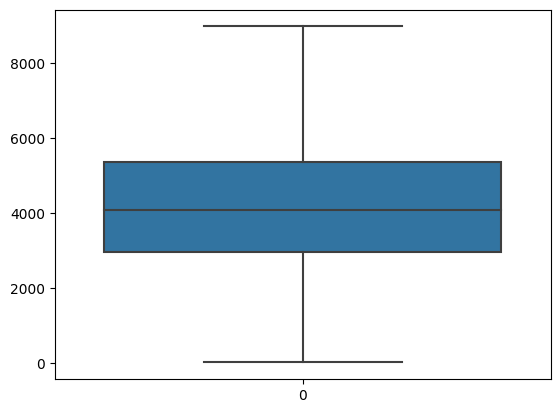

In [237]:
sns.boxplot(bimtra_df.query('solution > 0')['solution'], showfliers=False)

In [238]:
bimtra_df = bimtra_df.query('solution > 0')
q1 = bimtra_df['solution'].quantile(0.25)
q3 = bimtra_df['solution'].quantile(0.75)
iqr = q3 - q1

# Define a condition to filter outliers

condition = (bimtra_df['solution'] >= q1) & (bimtra_df['solution'] <= q3 + 1.5*iqr)

# Apply the condition to get a DataFrame without outliers
bimtra_df = bimtra_df[condition]

In [239]:
bimtra_df['solution'].describe()

count    203061.000000
mean       4811.956954
std        1504.150477
min        2965.000000
25%        3478.000000
50%        4647.000000
75%        5430.000000
max        8967.000000
Name: solution, dtype: float64

In [240]:
bimtra_df.dt_arr = bimtra_df.dt_arr.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
bimtra_df.dt_dep = bimtra_df.dt_dep.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
esperas_df.hora = esperas_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metaf_df.hora = metaf_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
metar_df.hora = metar_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_prev_df.hora = tc_prev_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
tc_real_df.hora = tc_real_df.hora.apply(lambda x: datetime.utcfromtimestamp(int(x)/1000))
test_data.hora_ref = pd.to_datetime(test_data.hora_ref)
test_data.dt_dep = pd.to_datetime(test_data.dt_dep)

In [241]:
bimtra_df['hora_ref'] = bimtra_df.dt_dep.apply(lambda x: x.replace(minute=0, second=0, microsecond=0))
bimtra_df.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref
2,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00
4,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00
6,052050016538ab736a254313ef009a6b,SBRJ,SBCF,2022-06-01 09:20:04,2022-06-01 10:10:10,3006,2022-06-01 09:00:00
7,9ee544f8f82e5036fbdf6984e918308b,SBSP,SBPA,2022-06-01 00:59:53,2022-06-01 02:23:52,5039,2022-06-01 00:00:00
8,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,2022-06-01 01:20:45,2022-06-01 02:44:25,5020,2022-06-01 01:00:00


In [242]:
tc_prev_df['aero_tcp'] = tc_prev_df['aero']
tc_prev_df = tc_prev_df.drop(['aero'], axis=1)
tc_real_df['aero_tcr'] = tc_real_df['aero']
tc_real_df = tc_real_df.drop(['aero'], axis=1)

display(tc_prev_df.head())
display(tc_real_df.head())
display(tc_real_df.shape)

,hora,troca,aero_tcp
0,2022-06-01 00:00:00,0,BR
1,2022-06-01 01:00:00,0,BR
2,2022-06-01 02:00:00,0,BR
3,2022-06-01 03:00:00,0,BR
4,2022-06-01 04:00:00,0,BR


,hora,nova_cabeceira,antiga_cabeceira,aero_tcr
0,2022-06-01 14:14:03,32,03,FL
1,2022-06-01 18:51:10,18,12,RF
2,2022-06-01 19:12:25,16,13,CF
3,2022-06-01 19:12:38,15,26,GL
4,2022-06-01 19:12:57,15,26,GL


(33431, 4)

In [243]:
tc_real_df.isna().sum()

hora                0
nova_cabeceira      0
antiga_cabeceira    0
aero_tcr            0
dtype: int64

In [244]:
esperas_df['aero_esperas'] = esperas_df['aero']
esperas_df = esperas_df.drop(['aero'], axis=1)
esperas_df['hora_esperas'] = esperas_df['hora']
esperas_df = esperas_df.drop(['hora'], axis=1)
esperas_df['hora_ref'] = esperas_df['hora_esperas'] #+ timedelta(hours=1)
esperas_df['destino'] = esperas_df['aero_esperas']

esperas_df.head()

,esperas,aero_esperas,hora_esperas,hora_ref,destino
0,0,SBBR,2022-06-01 00:00:00,2022-06-01 00:00:00,SBBR
1,0,SBBR,2022-06-01 01:00:00,2022-06-01 01:00:00,SBBR
2,0,SBBR,2022-06-01 02:00:00,2022-06-01 02:00:00,SBBR
3,0,SBBR,2022-06-01 03:00:00,2022-06-01 03:00:00,SBBR
4,0,SBBR,2022-06-01 04:00:00,2022-06-01 04:00:00,SBBR


In [245]:
print(f'bimtra_df: {bimtra_df.shape}')
print(f'esperas_df: {esperas_df.shape}')
print(f'metaf_df: {metaf_df.shape}')
print(f'metar_df: {metar_df.shape}')
print(f'tc_prev_df: {tc_prev_df.shape}')
print(f'tc_real_df: {tc_real_df.shape}')

bimtra_df: (203061, 7)
esperas_df: (99936, 5)
metaf_df: (43938, 3)
metar_df: (106744, 3)
tc_prev_df: (99936, 3)
tc_real_df: (33431, 4)


In [246]:
tc_real_df['hora_ref'] = tc_real_df.hora.apply(lambda x: x.replace(minute=0, second=0, microsecond=0)) 
tc_prev_df['hora_ref'] = tc_prev_df.hora #- timedelta(hours=1)

tc_real_df['hora_tcr'] = tc_real_df.hora
tc_prev_df['hora_tcp'] = tc_prev_df.hora
tc_real_df = tc_real_df.drop(['hora'], axis=1)
tc_prev_df = tc_prev_df.drop(['hora'], axis=1)

tc_real_df['destino'] = tc_real_df.aero_tcr
tc_prev_df['destino'] = tc_prev_df.aero_tcp


display(tc_real_df.head())
display(tc_prev_df.head())

,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_ref,hora_tcr,destino
0,32,03,FL,2022-06-01 14:00:00,2022-06-01 14:14:03,FL
1,18,12,RF,2022-06-01 18:00:00,2022-06-01 18:51:10,RF
2,16,13,CF,2022-06-01 19:00:00,2022-06-01 19:12:25,CF
3,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:38,GL
4,15,26,GL,2022-06-01 19:00:00,2022-06-01 19:12:57,GL


,troca,aero_tcp,hora_ref,hora_tcp,destino
0,0,BR,2022-06-01 00:00:00,2022-06-01 00:00:00,BR
1,0,BR,2022-06-01 01:00:00,2022-06-01 01:00:00,BR
2,0,BR,2022-06-01 02:00:00,2022-06-01 02:00:00,BR
3,0,BR,2022-06-01 03:00:00,2022-06-01 03:00:00,BR
4,0,BR,2022-06-01 04:00:00,2022-06-01 04:00:00,BR


In [247]:
tc_prev_df['destino'] = 'SB' + tc_prev_df['destino'].astype(str)
tc_prev_df['destino'].unique()

tc_real_df['destino'] = 'SB' + tc_real_df['destino'].astype(str)
tc_real_df['destino'].unique()

tc_prev_df['aero_tcp'] = 'SB' + tc_prev_df['aero_tcp'].astype(str)
tc_prev_df['aero_tcp'].unique()

tc_real_df['aero_tcr'] = 'SB' + tc_real_df['aero_tcr'].astype(str)
tc_real_df['aero_tcr'].unique()

array(['SBFL', 'SBRF', 'SBCF', 'SBGL', 'SBSV', 'SBKP', 'SBGR', 'SBPA',
       'SBRJ', 'SBSP', 'SBBR', 'SBCT'], dtype=object)

In [248]:
train_data = pd.merge(bimtra_df, esperas_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_prev_df, how='left', on=['hora_ref', 'destino'])
train_data = pd.merge(train_data, tc_real_df, how='left', on=['hora_ref', 'destino'])
# train_data['hora_ref'] = train_data['hora_ref'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [249]:
display(train_data.sample(10))
display(train_data.shape)


,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
141294,4373f95e0fe3efeaed695413442c5a1c,SBGL,SBBR,2023-01-08 21:44:05,2023-01-08 23:07:33,5008,2023-01-08 21:00:00,0,SBBR,2023-01-08 21:00:00,0,SBBR,2023-01-08 21:00:00,NaN,NaN,NaN,NaT
91724,66b474afcfefac2003cdc847b7390e0d,SBSV,SBRJ,2022-10-26 12:25:29,2022-10-26 14:23:15,7066,2022-10-26 12:00:00,0,SBRJ,2022-10-26 12:00:00,1,SBRJ,2022-10-26 12:00:00,NaN,NaN,NaN,NaT
203785,1c5d7481440cd031e8611582dc0f83df,SBFL,SBSP,2023-04-06 08:42:09,2023-04-06 09:34:29,3140,2023-04-06 08:00:00,0,SBSP,2023-04-06 08:00:00,0,SBSP,2023-04-06 08:00:00,NaN,NaN,NaN,NaT
176494,90faa6d660f0665c017983b30d324010,SBGL,SBSV,2023-02-28 19:28:46,2023-02-28 21:12:14,6208,2023-02-28 19:00:00,0,SBSV,2023-02-28 19:00:00,0,SBSV,2023-02-28 19:00:00,10,17,SBSV,2023-02-28 19:39:32
108237,ef6a76d3e1b6d3038eeb50fa3bf1ce62,SBCT,SBPA,2022-11-20 13:05:10,2022-11-20 13:59:55,3285,2022-11-20 13:00:00,0,SBPA,2022-11-20 13:00:00,0,SBPA,2022-11-20 13:00:00,NaN,NaN,NaN,NaT
62002,057dc8d2baf190a7c2962f96614f6996,SBSV,SBKP,2022-09-10 21:05:39,2022-09-10 23:18:36,7977,2022-09-10 21:00:00,2,SBKP,2022-09-10 21:00:00,0,SBKP,2022-09-10 21:00:00,15,33,SBKP,2022-09-10 21:42:33
157085,edb26a740ef205553c5c9e15606f27ec,SBRJ,SBSP,2023-01-31 19:44:36,2023-01-31 20:41:33,3417,2023-01-31 19:00:00,3,SBSP,2023-01-31 19:00:00,1,SBSP,2023-01-31 19:00:00,NaN,NaN,NaN,NaT
208684,302931e6f6d04e86c9649fdb0c6f1214,SBSP,SBSV,2023-04-11 13:57:49,2023-04-11 15:57:33,7184,2023-04-11 13:00:00,0,SBSV,2023-04-11 13:00:00,0,SBSV,2023-04-11 13:00:00,10,17,SBSV,2023-04-11 13:35:04
145598,3c9ea67df512873051e8447a98b522be,SBCF,SBSP,2023-01-14 10:47:25,2023-01-14 11:52:18,3893,2023-01-14 10:00:00,0,SBSP,2023-01-14 10:00:00,1,SBSP,2023-01-14 10:00:00,NaN,NaN,NaN,NaT
88934,c7f897ee38ee736bcc4d6044a9020dd4,SBBR,SBGL,2022-10-22 12:45:40,2022-10-22 14:01:13,4533,2022-10-22 12:00:00,0,SBGL,2022-10-22 12:00:00,1,SBGL,2022-10-22 12:00:00,NaN,NaN,NaN,NaT


(236107, 17)

In [250]:
train_data.isna().sum() 

flightid                 0
origem                   0
destino                  0
dt_dep                   0
dt_arr                   0
solution                 0
hora_ref                 0
esperas                  0
aero_esperas             0
hora_esperas             0
troca                    0
aero_tcp                 0
hora_tcp                 0
nova_cabeceira      153503
antiga_cabeceira    153503
aero_tcr            153503
hora_tcr            153503
dtype: int64

In [251]:
train_data.shape

(236107, 17)

In [252]:
train_data.head()

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,2022-06-01 00:26:52,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,2022-06-01 01:00:38,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT
2,052050016538ab736a254313ef009a6b,SBRJ,SBCF,2022-06-01 09:20:04,2022-06-01 10:10:10,3006,2022-06-01 09:00:00,0,SBCF,2022-06-01 09:00:00,0,SBCF,2022-06-01 09:00:00,NaN,NaN,NaN,NaT
3,9ee544f8f82e5036fbdf6984e918308b,SBSP,SBPA,2022-06-01 00:59:53,2022-06-01 02:23:52,5039,2022-06-01 00:00:00,0,SBPA,2022-06-01 00:00:00,0,SBPA,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,2022-06-01 01:20:45,2022-06-01 02:44:25,5020,2022-06-01 01:00:00,0,SBPA,2022-06-01 01:00:00,0,SBPA,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


In [253]:
train_data.columns


Index(['flightid', 'origem', 'destino', 'dt_dep', 'dt_arr', 'solution',
       'hora_ref', 'esperas', 'aero_esperas', 'hora_esperas', 'troca',
       'aero_tcp', 'hora_tcp', 'nova_cabeceira', 'antiga_cabeceira',
       'aero_tcr', 'hora_tcr'],
      dtype='object')

In [254]:
train_data.dt_dep, test_data.dt_dep = train_data.dt_dep.dt.hour, test_data.dt_dep.dt.hour

In [255]:
display(train_data.head())
display(test_data.head())

,flightid,origem,destino,dt_dep,dt_arr,solution,hora_ref,esperas,aero_esperas,hora_esperas,troca,aero_tcp,hora_tcp,nova_cabeceira,antiga_cabeceira,aero_tcr,hora_tcr
0,3162de7203a972f071d5a48e8f0f4828,SBBR,SBRJ,0,2022-06-01 01:43:45,4613,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,0,SBRJ,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
1,504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,1,2022-06-01 02:33:05,5547,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,0,SBFL,2022-06-01 01:00:00,NaN,NaN,NaN,NaT
2,052050016538ab736a254313ef009a6b,SBRJ,SBCF,9,2022-06-01 10:10:10,3006,2022-06-01 09:00:00,0,SBCF,2022-06-01 09:00:00,0,SBCF,2022-06-01 09:00:00,NaN,NaN,NaN,NaT
3,9ee544f8f82e5036fbdf6984e918308b,SBSP,SBPA,0,2022-06-01 02:23:52,5039,2022-06-01 00:00:00,0,SBPA,2022-06-01 00:00:00,0,SBPA,2022-06-01 00:00:00,NaN,NaN,NaN,NaT
4,e93e3b8510854a55f195788019b5763b,SBGR,SBPA,1,2022-06-01 02:44:25,5020,2022-06-01 01:00:00,0,SBPA,2022-06-01 01:00:00,0,SBPA,2022-06-01 01:00:00,NaN,NaN,NaN,NaT


,flightid,origem,destino,dt_dep,hora_ref,snapshot_radar,path,hora_esperas,esperas,aero_esperas,...,metaf,aero_metaf,hora_metar,metar,aero_metar,hora_tcp,troca,aero_tcp,hora_tcr,aero_tcr
0,7945735584a3297121c4f5ae0de8ecd1,SBKP,SBSV,11,2023-05-30 11:00:00,MULTIPOINT ((-0.8807200448127578 -0.5148453155...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-30 10:00:00.000,0,SBSV,...,NaN,NaN,2023-05-30 11:00:00.000,METAR SBSV 301100Z 12009KT 9999 FEW023 28/21 Q...,SBSV,2023-05-30 12:00:00.000,0,SBSV,NaN,NaN
1,85cb958e8b9d583575cd9cb93e389226,SBFL,SBRJ,8,2023-05-19 08:00:00,MULTIPOINT ((-0.8826266039383116 -0.4926305156...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-19 07:00:00.000,0,SBRJ,...,METAF SBRJ 190900Z 33004KT 9999 BKN033 ...,SBRJ,2023-05-19 08:00:00.000,METAR SBRJ 190800Z 02004KT 9999 FEW010 SCT040 ...,SBRJ,2023-05-19 09:00:00.000,0,SBRJ,NaN,NaN
2,2d4e8cd3947525a12ff16af520beefb9,SBCF,SBGR,11,2023-05-22 11:00:00,MULTIPOINT ((-0.8972512464147154 -0.5215196550...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-22 10:00:00.000,0,SBGR,...,METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n,SBGR,2023-05-22 11:00:00.000,METAR SBGR 221100Z 07006KT CAVOK 13/12 Q1022=,SBGR,2023-05-22 12:00:00.000,0,SBGR,NaN,NaN
3,24cf317a1494a016a018d9f5cd183639,SBFL,SBSP,16,2023-05-29 16:00:00,MULTIPOINT ((-0.892972783728755 -0.51704889771...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-29 15:00:00.000,2,SBSP,...,METAF SBSP 291700Z 15010KT 9999 OVC033 ...,SBSP,2023-05-29 16:00:00.000,METAR SBSP 291600Z 12010KT 090V160 9999 SCT015...,SBSP,2023-05-29 17:00:00.000,0,SBSP,NaN,NaN
4,370babaf32dc82a6a64bf5b71a3434ed,SBCF,SBKP,22,2023-05-25 22:00:00,MULTIPOINT ((-0.8970045369724385 -0.5240544927...,http://satelite.cptec.inpe.br/repositoriogoes/...,2023-05-25 21:00:00.000,0,SBKP,...,METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n,SBKP,2023-05-25 22:00:00.000,METAR SBKP 252200Z 09004KT CAVOK 23/13 Q1020=,SBKP,2023-05-25 23:00:00.000,0,SBKP,NaN,NaN


In [256]:
metar_df.metar = metar_df.metar.apply(lambda x: x.replace('=', ''))

metar_df['temperature_real'] = None
metar_df['dew_point_real'] = None
metar_df['wind_direction_real'] = None
metar_df['visibility_real'] = None
metar_df['wind_speed_real'] = None
metar_df['pressure_real'] = None

for i, report in enumerate(metar_df['metar']):
    try:
        report = Metar.Metar(report)
        metar_df.at[i, 'temperature_real'] = report.temp.value()
        metar_df.at[i, 'dew_point_real'] = report.dewpt.value()
        metar_df.at[i, 'wind_direction_real'] = report.wind_dir.value()
        metar_df.at[i, 'visibility_real'] = report.vis.value()
        metar_df.at[i, 'wind_speed_real'] = report.wind_speed.value()
        metar_df.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [257]:
test_data.metar = test_data.metar.apply(lambda x: x.replace('=', ''))

test_data['temperature_real'] = None
test_data['dew_point_real'] = None
test_data['wind_direction_real'] = None
test_data['visibility_real'] = None
test_data['wind_speed_real'] = None
test_data['pressure_real'] = None

for i, report in enumerate(test_data['metar']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_real'] = report.temp.value()
        test_data.at[i, 'dew_point_real'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_real'] = report.wind_dir.value()
        test_data.at[i, 'visibility_real'] = report.vis.value()
        test_data.at[i, 'wind_speed_real'] = report.wind_speed.value()
        test_data.at[i, 'pressure_real'] = report.press.value()
    except:
        continue

In [258]:
test_data.metaf

0                                                   NaN
1     METAF SBRJ 190900Z  33004KT 9999       BKN033 ...
2       METAF SBGR 221200Z 04003KT CAVOK 19/09 Q1021=\n
3     METAF SBSP 291700Z  15010KT 9999       OVC033 ...
4       METAF SBKP 252300Z 08008KT CAVOK 21/12 Q1019=\n
5     METAF SBGR 241000Z 06005KT 3000     BR BKN033 ...
6      METAF SBKP 162000Z  18003KT CAVOK 23/08 Q1017=\n
7      METAF SBCT 270100Z  35004KT CAVOK 16/11 Q1019=\n
8     METAF SBSP 311600Z 06004KT 9999    RA  OVC023 ...
9                                                   NaN
10                                                  NaN
11      METAF SBBR 221500Z 08006KT CAVOK 23/07 Q1019=\n
12     METAF SBCF 170100Z  13006KT CAVOK 13/09 Q1017=\n
13    METAF SBRJ 311700Z  10009KT 9999  -TSRA  OVC02...
14    METAF SBRJ 311700Z  10009KT 9999  -TSRA  OVC02...
15    METAF SBSP 291500Z  14010KT 9999       OVC033 ...
16     METAF SBBR 191100Z  10005KT CAVOK 17/04 Q1019=\n
17    METAF SBSP 162100Z  17008KT 9999       BKN

In [259]:
test_data.metaf = test_data.metaf.fillna('')

In [260]:
replace_equals_newline = lambda x: x.replace('=\n', ' ')
replace_metaf = lambda x: x.replace('METAF', 'METAR')

metaf_df.metaf = metaf_df.metaf.apply(replace_equals_newline)
metaf_df.metaf = metaf_df.metaf.apply(replace_metaf)

test_data.metaf = test_data.metaf.apply(replace_equals_newline)
test_data.metaf = test_data.metaf.apply(replace_metaf)

In [261]:
metaf_df.shape

(43938, 3)

In [262]:
metaf_df['temperature_prev'] = None
metaf_df['dew_point_prev'] = None
metaf_df['wind_direction_prev'] = None
metaf_df['visibility_prev'] = None
metaf_df['wind_speed_prev'] = None
metaf_df['pressure_prev'] = None

for i, report in enumerate(metaf_df['metaf']):
    try:
        report = Metar.Metar(report)
        metaf_df.at[i, 'temperature_prev'] = report.temp.value()
        metaf_df.at[i, 'dew_point_prev'] = report.dewpt.value()
        metaf_df.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        metaf_df.at[i, 'visibility_prev'] = report.vis.value()
        metaf_df.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        metaf_df.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [263]:
test_data['temperature_prev'] = None
test_data['dew_point_prev'] = None
test_data['wind_direction_prev'] = None
test_data['visibility_prev'] = None
test_data['wind_speed_prev'] = None
test_data['pressure_prev'] = None

for i, report in enumerate(test_data['metaf']):
    try:
        report = Metar.Metar(report)
        test_data.at[i, 'temperature_prev'] = report.temp.value()
        test_data.at[i, 'dew_point_prev'] = report.dewpt.value()
        test_data.at[i, 'wind_direction_prev'] = report.wind_dir.value()
        test_data.at[i, 'visibility_prev'] = report.vis.value()
        test_data.at[i, 'wind_speed_prev'] = report.wind_speed.value()
        test_data.at[i, 'pressure_prev'] = report.press.value()
    except:
        continue

In [264]:
metaf_df.sample(5)

,hora,metaf,aero,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev
18203,2022-08-12 14:00:00,METAR SBGR 121400Z 10006KT 9999 FEW028 ...,SBGR,16.0,9.0,100.0,10000.0,6.0,1027.0
3690,2023-04-11 06:00:00,METAR SBCF 110600Z 12005KT 0800 FG OVC020...,SBCF,16.0,16.0,120.0,800.0,5.0,1017.0
20715,2022-12-09 17:00:00,METAR SBGR 091700Z 28005KT CAVOK 32/12 Q1008,SBGR,32.0,12.0,280.0,10000.0,5.0,1008.0
28635,2022-12-22 05:00:00,METAR SBKP 220500Z 12009KT 2000 BR BKN033...,SBKP,16.0,15.0,120.0,2000.0,9.0,1012.0
19554,2022-10-16 12:00:00,METAR SBGR 161200Z 06003KT CAVOK 22/15 Q1020,SBGR,22.0,15.0,60.0,10000.0,3.0,1020.0


In [265]:
metaf_df.shape

(43938, 9)

In [266]:
metar_df['hora_ref'], metaf_df['hora_ref'] = pd.to_datetime(metar_df['hora']), pd.to_datetime(metaf_df['hora']) #- timedelta(hours=1)

In [267]:
metar_metaf = pd.merge(metar_df, metaf_df, how='left', on=['hora_ref', 'aero'])
metar_metaf.shape

(106744, 18)

In [268]:
metar_metaf['destino'] = metar_metaf['aero']
metar_metaf = metar_metaf.drop(['aero'], axis=1)

In [269]:
train_data.shape

(236107, 17)

In [270]:
metar_metaf.head()

,hora_x,metar,temperature_real,dew_point_real,wind_direction_real,visibility_real,wind_speed_real,pressure_real,hora_ref,hora_y,metaf,temperature_prev,dew_point_prev,wind_direction_prev,visibility_prev,wind_speed_prev,pressure_prev,destino
0,2022-06-01 00:00:00,METAR SBBR 010000Z 07002KT CAVOK 21/08 Q1018,21.0,8.0,70.0,10000.0,2.0,1018.0,2022-06-01 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
1,2022-06-01 01:00:00,METAR SBBR 010100Z 10002KT CAVOK 20/09 Q1019,20.0,9.0,100.0,10000.0,2.0,1019.0,2022-06-01 01:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
2,2022-06-01 02:00:00,METAR SBBR 010200Z 00000KT CAVOK 16/09 Q1019,16.0,9.0,0.0,10000.0,0.0,1019.0,2022-06-01 02:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
3,2022-06-01 03:00:00,METAR SBBR 010300Z 27002KT CAVOK 16/09 Q1019,16.0,9.0,270.0,10000.0,2.0,1019.0,2022-06-01 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR
4,2022-06-01 04:00:00,METAR SBBR 010400Z 00000KT CAVOK 14/09 Q1018,14.0,9.0,0.0,10000.0,0.0,1018.0,2022-06-01 04:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SBBR


In [271]:
train_data = pd.merge(train_data, metar_metaf, how='left', on=['hora_ref', 'destino'])

In [272]:
le = LabelEncoder()

cat_columns = ['origem', 'destino', 'aero_esperas', 'aero_tcp', 'aero_tcr']
display(train_data[cat_columns].head())
train_data[cat_columns], test_data[cat_columns] = train_data[cat_columns].apply(le.fit_transform), test_data[cat_columns].apply(le.fit_transform)

for column in train_data.columns:
    if column == 'solution':
        continue
    if column not in test_data.columns:
        test_data[column] = 0

,origem,destino,aero_esperas,aero_tcp,aero_tcr
0,SBBR,SBRJ,SBRJ,SBRJ,NaN
1,SBCF,SBFL,SBFL,SBFL,NaN
2,SBRJ,SBCF,SBCF,SBCF,NaN
3,SBSP,SBPA,SBPA,SBPA,NaN
4,SBGR,SBPA,SBPA,SBPA,NaN


In [273]:
train_data[cat_columns].head()

,origem,destino,aero_esperas,aero_tcp,aero_tcr
0,0,9,9,9,12
1,1,3,3,3,12
2,9,1,1,1,12
3,10,7,7,7,12
4,5,7,7,7,12


In [274]:
train_data['rota'], test_data['rota'] = train_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1), test_data[['origem', 'destino']].apply(lambda x: '-'.join(sorted(map(str, x))), axis=1)
train_data['rota'], test_data['rota'] = train_data['rota'].apply(lambda x: x.replace('-', '')), test_data['rota'].apply(lambda x: x.replace('-', ''))
display(train_data['rota'].head())


0     09
1     13
2     19
3    107
4     57
Name: rota, dtype: object

In [275]:
np.count_nonzero(train_data.rota.unique())

68

In [276]:
train_data['solution'].describe()

count    236107.000000
mean       4885.493984
std        1522.291787
min        2965.000000
25%        3516.000000
50%        4695.000000
75%        5684.500000
max        8967.000000
Name: solution, dtype: float64

<Axes: xlabel='rota', ylabel='solution'>

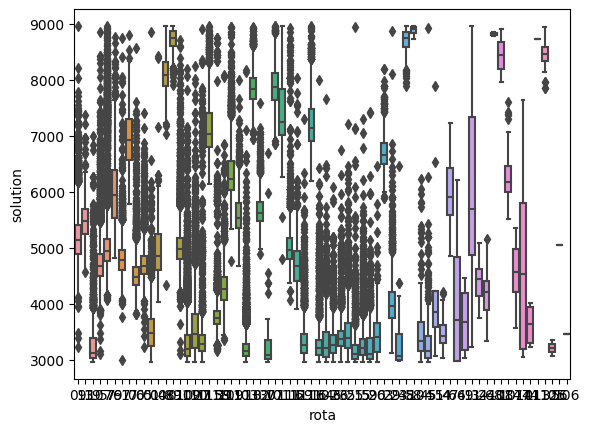

In [277]:
sns.boxplot(data=train_data, x='rota', y='solution')

In [278]:
train_data.shape

(236107, 34)

In [279]:
for column in train_data.columns:
    if train_data[column].isna().sum():
        print(column)

nova_cabeceira
antiga_cabeceira
hora_tcr
hora_x
metar
temperature_real
dew_point_real
wind_direction_real
visibility_real
wind_speed_real
pressure_real
hora_y
metaf
temperature_prev
dew_point_prev
wind_direction_prev
visibility_prev
wind_speed_prev
pressure_prev


In [280]:
columns0 = ['esperas', 'troca']
columns_mean = ['temperature_real',
'dew_point_real',
'wind_direction_real',
'visibility_real',
'wind_speed_real',
'pressure_real',
'temperature_prev',
'dew_point_prev',
'wind_direction_prev',
'visibility_prev',
'wind_speed_prev',
'pressure_prev']

In [281]:
train_data[columns0] = train_data[columns0].fillna(0)
train_data[columns_mean] = train_data[columns_mean].fillna(train_data[columns_mean].mean())

test_data[columns0] = test_data[columns0].fillna(0)
test_data[columns_mean] = test_data[columns_mean].fillna(test_data[columns_mean].mean())

In [282]:
train_data = train_data.drop(columns=['nova_cabeceira', 'antiga_cabeceira', 'dt_arr', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref', 'metar', 'metaf', 'hora_x', 'hora_y'], axis=1)
test_data = test_data.drop(columns=['snapshot_radar', 'path', 'hora_metaf', 'metaf', 'aero_metaf', 'hora_metar', 'metar', 'aero_metar', 'hora_esperas', 'hora_tcp', 'hora_tcr', 'hora_ref'], axis=1)

In [283]:
for column in train_data.columns:
    if column not in test_data.columns:
        print(column)

solution


In [284]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236107 entries, 0 to 236106
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   flightid             236107 non-null  object 
 1   origem               236107 non-null  int64  
 2   destino              236107 non-null  int64  
 3   dt_dep               236107 non-null  int32  
 4   solution             236107 non-null  int64  
 5   esperas              236107 non-null  int64  
 6   aero_esperas         236107 non-null  int64  
 7   troca                236107 non-null  int64  
 8   aero_tcp             236107 non-null  int64  
 9   aero_tcr             236107 non-null  int64  
 10  temperature_real     236107 non-null  float64
 11  dew_point_real       236107 non-null  float64
 12  wind_direction_real  236107 non-null  float64
 13  visibility_real      236107 non-null  float64
 14  wind_speed_real      236107 non-null  float64
 15  pressure_real    

In [285]:
scaler = StandardScaler()

# Modeling

In [286]:
features = train_data.columns
features = features.drop(['flightid', 'solution'])
train_data[features] = scaler.fit_transform(train_data[features])
target = 'solution'

X_train, X_test, y_train, y_test = train_test_split(train_data[features], train_data[target], test_size=0.2, random_state=42)

In [287]:
# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# print(f'Linear Regression MSE: {mean_squared_error(y_test, y_pred)}')

model2 = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
y_pred = np.round_(y_pred)
print(y_pred)
print(f'Random Forest Regressor MSE: {mean_squared_error(y_test, y_pred)}')

[7659. 4012. 3945. ... 3261. 4919. 6104.]
Random Forest Regressor MSE: 120891.22578459192


# Submission

In [288]:
X_train, y_train = train_data[features], train_data[target]
X_test = test_data[features]
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred = np.round_(y_pred)
print(y_pred)

output = pd.DataFrame({'ID': test_data.flightid, 'solution': y_pred})

output.to_csv('data/submission.csv', index=False)

[7521. 7521. 7436. 7507. 7436. 7462. 7495. 7429. 7498. 7436. 7521. 7803.
 5595. 7521. 7521. 7521. 7818. 7498. 7492. 7805. 7521. 7521. 7439. 7498.
 7521. 7412. 7521. 7818. 7818. 7345. 7805. 7495. 7521. 7434. 7482. 7434.
 7495. 7521. 7392. 7444. 7412. 7409. 7498. 7436. 7382. 7819. 7803. 7521.
 7842. 7417. 7521. 7521. 7812. 7495. 7521. 7521. 5362. 7521. 7436. 7467.
 7374. 7521. 7818. 7495. 7803. 6832. 7434. 7498. 7436. 7431. 7431. 7521.
 7436. 6475. 7498. 7756. 7521. 7507. 7461. 7331. 7521. 7521. 7521. 7467.
 7803. 7521. 7521. 7521. 7498. 7467. 7521. 7521. 7521. 7521. 7521. 7467.
 7436. 7441. 7436. 7485.]
